## Preparing the data set

The first step before running the clustering algorithm is to prepare the training and the testing data set. 


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", color_codes=True)
sns.palplot(sns.color_palette("RdBu", n_colors=7))

fileNameTrain = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\train.json\\train.json"
train_df = pd.read_json(fileNameTrain)

fileNameTest = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\test.json\\test.json"
test_df = pd.read_json(fileNameTest)



In [6]:
lower_limit_lon = np.percentile(train_df.longitude.values, 1)
upper_limit_lon = np.percentile(train_df.longitude.values, 99)
train_df['longitude'].ix[train_df['longitude']<lower_limit_lon] = lower_limit_lon
train_df['longitude'].ix[train_df['longitude']>upper_limit_lon] = upper_limit_lon
test_df['longitude'].ix[test_df['longitude']<lower_limit_lon] = lower_limit_lon
test_df['longitude'].ix[test_df['longitude']>upper_limit_lon] = upper_limit_lon

lower_limit_lat = np.percentile(train_df.latitude.values, 1)
upper_limit_lat = np.percentile(train_df.latitude.values, 99)
train_df['latitude'].ix[train_df['latitude']<lower_limit_lat] = lower_limit_lat
train_df['latitude'].ix[train_df['latitude']>upper_limit_lat] = upper_limit_lat
test_df['latitude'].ix[test_df['latitude']<lower_limit_lat] = lower_limit_lat
test_df['latitude'].ix[test_df['latitude']>upper_limit_lat] = upper_limit_lat

In [7]:
import shapefile

sf = shapefile.Reader("C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\ZillowNeighborhoods-NY\\ZillowNeighborhoods-NY.shp")

shapes = sf.shapes()
records = sf.records()

towns_values = [records[i][2] for i in range(len(records))]
neighb_values = [records[i][3] for i in range(len(records))]
west_values = [shapes[i].bbox[0] for i in range(len(records))]
south_values = [shapes[i].bbox[1] for i in range(len(records))]
east_values = [shapes[i].bbox[2] for i in range(len(records))]
north_values = [shapes[i].bbox[3] for i in range(len(records))]

west, south, east, north = -74.02, 40.64, -73.85, 40.86

neighbourhood_pd = pd.DataFrame({'Town' : towns_values,
                                 'Neighbourhood' : neighb_values,
                                 'West' : west_values,
                                 'South' : south_values,
                                 'East' : east_values,
                                 'North' : north_values})

neighbourhood_pd = neighbourhood_pd[neighbourhood_pd.Town == "New York"]
neighbourhood_pd = neighbourhood_pd.ix[(neighbourhood_pd.West >= west) & 
                                     (neighbourhood_pd.East <= east) & 
                                     (neighbourhood_pd.South >= south) & 
                                     (neighbourhood_pd.North <= north)]

neighbourhood_sorted_pd = neighbourhood_pd.sort_values(['West'])


neighbourhood_ls = []
for num in range(0, train_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>train_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<train_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>train_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
train_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=train_df.index)

neighbourhood_ls = []
for num in range(0, test_df.shape[0]):
    temp = neighbourhood_sorted_pd[(neighbourhood_sorted_pd.West<test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.East>test_df.longitude.values[num]) &
                                   (neighbourhood_sorted_pd.South<test_df.latitude.values[num]) &
                                   (neighbourhood_sorted_pd.North>test_df.latitude.values[num])]
    if temp.shape[0] > 0:
        neighbourhood_ls += [temp.Neighbourhood.values[0]]
    else:
        neighbourhood_ls += ["Other"]
    
test_df['neighbourhood'] = pd.Series(neighbourhood_ls, index=test_df.index)

As a next step, we will extract the key words from the description variable - by key words, we define words that are in the description of the unit but are not stop words as defined by the ntlk.corpus package.

In [8]:
from nltk.corpus import stopwords

cachedStopWords = stopwords.words("english")

description_key_words_ls = []

for ind, row in train_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

train_df['description_key_words'] = pd.Series(description_key_words_ls, index=train_df.index)

description_key_words_ls = []

for ind, row in test_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

test_df['description_key_words'] = pd.Series(description_key_words_ls, index=test_df.index)

We will create two numeric variables which describe the number of features and number of key words in the description section

In [9]:
train_df['num_features'] = train_df.features.apply(len)
train_df['num_key_words_description'] = train_df.description_key_words.apply(len)

test_df['num_features'] = test_df.features.apply(len)
test_df['num_key_words_description'] = test_df.description_key_words.apply(len)

From the Created variable, we will extract into new variables the exact data when the listing was created, the day of year, week of year, weekday and hour.

In [10]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date"]= train_df["created"].dt.date

train_df["dayofyear"] = train_df["created"].dt.dayofyear
train_df["weekofyear"] = train_df["created"].dt.weekofyear
train_df["weekday"] = train_df["created"].dt.weekday
train_df["hour"] = train_df["created"].dt.hour

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date"]= test_df["created"].dt.date

test_df["dayofyear"] = test_df["created"].dt.dayofyear
test_df["weekofyear"] = test_df["created"].dt.weekofyear
test_df["weekday"] = test_df["created"].dt.weekday
test_df["hour"] = test_df["created"].dt.hour

The train and the test data set are ready so the next step is to apply the XGBoost algorithm.


In [45]:
selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour"]
train_X = train_df[selected_vars]
test_X = test_df[selected_vars]

target_num_map = {'high':0, 'medium':1, 'low':2}
#train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
train_y = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print(train_X.shape, test_X.shape)

preds, model = runXGB(train_X, train_y, test_X, num_rounds=400)
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values


(49352, 9) (74659, 9)
       high    medium       low  listing_id
0  0.047830  0.386779  0.565391     7142618
1  0.075124  0.243756  0.681121     7210040
2  0.004342  0.078086  0.917572     7103890
3  0.044818  0.398743  0.556439     7143442
4  0.008197  0.129960  0.861842     6860601
<class 'numpy.ndarray'>


In [107]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelXGBfit(train_df, test_df, predictors, target, target_num_map, cv_folds=5, early_stopping_rounds=50):
    
    alg = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softprob; num_class=3',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
    
    #Fit the algorithm on the data
    #alg.set_params(n_estimators = 3)
    train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    alg.fit(train_df[predictors], train_target)
        
    #Predict training set:
    train_predictions = alg.predict(train_df[predictors])
    train_predprob = alg.predict_proba(train_df[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_target, train_predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    #Predicting on the test data set
    test_predictions = alg.predict(test_df[predictors])
    test_predprob = alg.predict_proba(test_df[predictors])
    return test_predictions, test_predprob, alg


We will use the modelXGBfit function to run the model. The function defines some of the paramteres needed by the xgboost algorithm. We will apply the algorithm to the train data set with the pre selected variables and target variable "interest_level".


Model Report
Accuracy : 0.8116


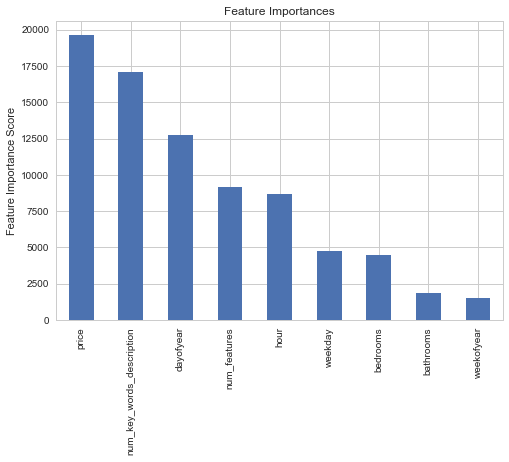

In [108]:
selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour"]
target = "interest_level"
target_num_map = {'high':0, 'medium':1, 'low':2}

test_prediction, test_predprob, alg = modelXGBfit (train_df, test_df, selected_vars, target, target_num_map)

Based on the XGBoost algorithm which was trained on the train_df data set, we can see that the trained model has accuracy of 81%. And the strongest predictors used by the model are: price, nm of key words in the desciption (or in other words how long is the description when the stp wprds are removed), day of the year, number of features, hour. Weekday, bedrooms and bathrooms are with less important function when predicting the probabilities the interest level.

In [112]:
out_df = pd.DataFrame(test_predprob)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
print(out_df.head())

       high    medium       low  listing_id
0  0.046830  0.369601  0.583569     7142618
1  0.113227  0.226515  0.660258     7210040
2  0.003342  0.080969  0.915689     7103890
3  0.031125  0.368529  0.600345     7143442
4  0.008309  0.078307  0.913383     6860601


As a next step we will perform cross validation and some fine tuning to the parameters of XGBoost.